In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [246]:

g_score = pd.read_csv('C:/Users/saleh/Desktop/SM/data movielens/ml-25m/genome-scores.csv')
g_tags = pd.read_csv('C:/Users/saleh/Desktop/SM/data movielens/ml-25m/genome-tags.csv')
links = pd.read_csv('C:/Users/saleh/Desktop/SM/data movielens/ml-25m/links.csv')
movies = pd.read_csv('C:/Users/saleh/Desktop/SM/data movielens/ml-25m/movies.csv')
ratings = pd.read_csv('C:/Users/saleh/Desktop/SM/data movielens/ml-25m/ratings.csv')
tags = pd.read_csv('C:/Users/saleh/Desktop/SM/data movielens/ml-25m/tags.csv')


In [26]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [181]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


1. Number of Ratings
2. Matrix of userid and movie title
3. Content Based Reco

    i. User - User Similarity
    
    ii. Item - Item similarity
    

In [247]:
#Number of users
print('Total Users: {0}'.format(ratings.userId.nunique()))
#Number of Movies
print('Total Movies: {0}'.format(ratings.movieId.nunique()))

Total Users: 162541
Total Movies: 59047


In [283]:
# Filter data for users with atleast 500 ratings

from collections import Counter

threshold_count = 499
c = Counter(ratings.userId)
relevant_items = [k for k, count in c.items() if count > threshold_count]

print(np.shape(relevant_items))
filtered_users = ratings.loc[ratings.userId.isin(relevant_items),:]

print(np.shape(filtered_users))

# Filter data for movies with atleast 100 ratings

threshold_count = 99
c = Counter(filtered_users.movieId)
relevant_items = [k for k, count in c.items() if count > threshold_count]

print(np.shape(relevant_items))
filtered_users = filtered_users.loc[filtered_users.movieId.isin(relevant_items),:]

print(np.shape(filtered_users))

(9713,)
(8960061, 4)
(8955,)
(8425494, 4)


In [284]:
#Number of users
print('Filtered Users: {0}'.format(filtered_users.userId.nunique()))
#Number of Movies
print('Filtered Movies: {0}'.format(filtered_users.movieId.nunique()))

Filtered Users: 9713
Filtered Movies: 8955


In [285]:
#Create a mapping for userIds and movieIds

movieid_map = pd.DataFrame(filtered_users.movieId.unique()).sort_values(by=0)
movieid_map.columns = ['movieId']
movieid_map['moviemap'] = range(1,len(movieid_map)+1)

filtered_ratings = pd.merge(filtered_users, movieid_map, how='left', on='movieId')


userid_map = pd.DataFrame(filtered_users.userId.unique()).sort_values(by=0)
userid_map.columns = ['userId']
userid_map['usermap'] = range(1,len(userid_map)+1)

filtered_ratings = pd.merge(filtered_ratings, userid_map, how='left', on='userId')


In [286]:
filtered_ratings.head()

,userId,movieId,rating,timestamp,moviemap,usermap
0,3,1,4.0,1439472215,1,1
1,3,29,4.5,1484754967,29,1
2,3,32,4.5,1439474635,32,1
3,3,50,5.0,1439474391,48,1
4,3,111,4.0,1484753849,95,1


In [287]:
# Number of ratings for each movie
rating_stats = pd.DataFrame(filtered_ratings.groupby('movieId').count()['userId'])

rating_stats['mean_rating'] = filtered_ratings.groupby('movieId').mean()['rating']

In [288]:
rating_stats.sort_values('userId',ascending=True).head()

,userId,mean_rating
movieId,,
4944,100,2.045
6120,100,2.860
1928,100,2.920
130684,100,2.785
166291,100,3.845


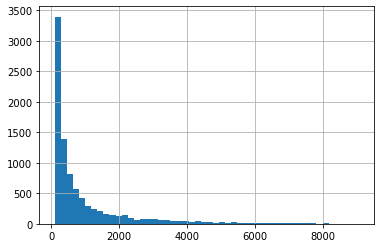

In [289]:
rating_stats['userId'].hist(bins=50)

In [290]:
# Create a matrix of user movie ratings

user_movie_matrix = np.zeros((filtered_ratings.userId.nunique(), filtered_ratings.movieId.nunique()))
for line in filtered_ratings.itertuples():
    user_movie_matrix[line[6]-1, line[5]-1] = line[3]


In [291]:
#Calculate Sparsity
sparsity = float(len(user_movie_matrix.nonzero()[0]))
sparsity /= (user_movie_matrix.shape[0] * user_movie_matrix.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 9.69%


In [292]:
np.shape(user_movie_matrix)

(9713, 8955)

In [302]:
# define a function to calculate cosine similarity
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = np.dot(ratings, ratings.T) + epsilon
    elif kind == 'item':
        sim = np.dot(ratings.T, ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [293]:
# Create a train and test dataset. The test data will have 10 ratings from all the users. 
# The remaing ratings will be used as training.

def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(user_movie_matrix)

In [294]:
test.astype(bool).sum(axis=1).mean()

10.0

In [295]:
user_similarity = similarity(user_movie_matrix, kind='user')
movie_similarity = similarity(user_movie_matrix, kind='item')

print(user_similarity[:4, :4])

[[1.         0.17824206 0.12556622 0.15166287]
 [0.17824206 1.         0.39180012 0.26099148]
 [0.12556622 0.39180012 1.         0.39455348]
 [0.15166287 0.26099148 0.39455348 1.        ]]


In [297]:
np.shape(user_similarity)

(9713, 9713)

In [318]:
def predict_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return np.dot(similarity,ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return np.dot(ratings,similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [319]:
user_predictions = predict_simple(user_movie_matrix,user_similarity)

In [320]:
np.shape(user_predictions)

(9713, 8955)

In [325]:
test[test.nonzero()]

array([3.5, 4. , 3. , ..., 1. , 5. , 3. ])

In [326]:
user_predictions[test.nonzero()]

array([2.63146655, 0.52914744, 1.74858805, ..., 0.7407964 , 0.65339357,
       0.49655976])

In [327]:
from sklearn.metrics import mean_squared_error
mean_squared_error(user_predictions[test.nonzero()],test[test.nonzero()])

6.467554467100021